In [2]:
import os
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
from tensorflow import feature_column as fc
plt.rcParams["font.family"] = 'NanumBarunGothic'
TENSORBOARD_BINARY = '/home/hoondori/anaconda3/envs/ai/bin/tensorboard'
os.environ['TENSORBOARD_BINARY'] =  TENSORBOARD_BINARY
%load_ext tensorboard

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# 회귀

## Estimator 기반 타이타닉 문제

* https://www.tensorflow.org/tutorials/estimator/linear?hl=ko

### 타이타닉 데이터셋 확보

In [3]:
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [4]:
dftrain.shape, dfeval.shape[0]

((627, 9), 264)

In [5]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [6]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


### Feature engineering

In [7]:
CAT_COLS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUM_COLS = ['age', 'fare']

feature_columns = []
for feature_name in CAT_COLS:
    voca = dftrain[feature_name].unique()
    feature_columns.append(fc.categorical_column_with_vocabulary_list(feature_name, voca))
    
for feature_name in NUM_COLS:
    feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))
#feature_columns 

### Input_fn 정의

In [8]:
def make_input_fn(data_df, label_df, shuffle=True, epochs=10, batch_size=32):

    def input_fn():
        #  
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if( shuffle):
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(epochs)
        return ds
    
    return input_fn

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, epochs=1)

In [9]:
ds = make_input_fn(dftrain, y_train, batch_size=5)()
for f, l in ds.take(1):
    print(list(f.keys()))
    print(f['class'].numpy())
    print(l.numpy())

['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
[b'Third' b'Second' b'First' b'Second' b'Second']
[0 0 0 1 0]


### 훈련

In [10]:
linear_classifier = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_classifier.train(train_input_fn)
eval_result = linear_classifier.evaluate(eval_input_fn)
# linear_classifier.get_variable_names()

clear_output()
print(eval_result)

{'accuracy': 0.7348485, 'accuracy_baseline': 0.625, 'auc': 0.8343128, 'auc_precision_recall': 0.79315144, 'average_loss': 0.48207965, 'label/mean': 0.375, 'loss': 0.47611183, 'precision': 0.6407767, 'prediction/mean': 0.41162443, 'recall': 0.6666667, 'global_step': 200}


### 평가

<AxesSubplot:title={'center':'예측 확률'}, ylabel='Frequency'>

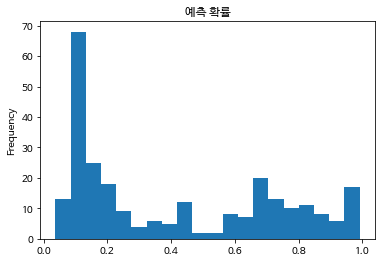

In [13]:
pred_dicts = list(linear_classifier.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

clear_output()
probs.plot(kind='hist', bins=20, title='예측 확률')

(0.0, 1.05)

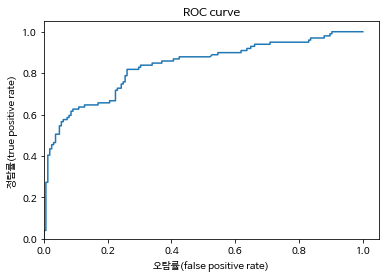

In [16]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('오탐률(false positive rate)')
plt.ylabel('정탐률(true positive rate)')
plt.xlim(0,)
plt.ylim(0,)

## Estimator 기반 MNIST 예측기

In [5]:
def estimate_mnist(log_dir):
    
    # load data
    ((train_data, train_labels),(eval_data, eval_labels)) = tf.keras.datasets.mnist.load_data()    
    train_data = train_data/np.float32(255)
    train_labels = train_labels.astype(np.int32)  
    eval_data = eval_data/np.float32(255)
    eval_labels = eval_labels.astype(np.int32)    

    # estimator 정의
    classifier = tf.estimator.LinearClassifier(
        feature_columns=[tf.feature_column.numeric_column("x", shape=[28, 28])],
        n_classes=10,
        model_dir=log_dir
    )
    
    # input fn
    train_input_fn =  tf.compat.v1.estimator.inputs.numpy_input_fn(
        x={"x": train_data},
        y=train_labels,
        batch_size=100,
        num_epochs=None,
        shuffle=True)
    
    val_input_fn =  tf.compat.v1.estimator.inputs.numpy_input_fn(
        x={"x": eval_data},
        y=eval_labels,
        num_epochs=1,
        shuffle=False)
    
    # train
    classifier.train(input_fn=train_input_fn, steps=10000)
    
    # eval
    clear_output()
    eval_results = classifier.evaluate(input_fn=val_input_fn)
    #print(eval_results)

!rm -rf /tmp/logs/mnist     
estimate_mnist('/tmp/logs/mnist')    

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-02-03T14:54:16Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/logs/mnist/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.12964s
INFO:tensorflow:Finished evaluation at 2021-02-03-14:54:17
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.9248, average_loss = 0.26681885, global_step = 10000, loss = 0.2653051
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10000: /tmp/logs/mnist/model.ckpt-10000


In [6]:
%tensorboard --logdir /tmp/logs/mnist

Reusing TensorBoard on port 6010 (pid 51732), started 0:06:21 ago. (Use '!kill 51732' to kill it.)

## Estimator 기반 보스턴 집값 Regression

In [3]:
def estimate_boston_house(log_dir):

    def estimator_input_fn(df_data, df_label, epochs=20, shuffle=True, batch_size=64):
        def input_function():
            ds = tf.data.Dataset.from_tensor_slices((dict(df_data), df_label))
            if shuffle:
                ds = ds.shuffle(100)
            ds = ds.batch(batch_size).repeat(epochs)
            return ds
        return input_function

    # data / input fn 준비
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data()    

    features = ['CRIM', 'ZN', 'INDUS','CHAS','NOX','RM','AGE',
            'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
    x_train_df = pd.DataFrame(x_train, columns= features)
    x_test_df = pd.DataFrame(x_test, columns= features)
    y_train_df = pd.DataFrame(y_train, columns=['MEDV'])
    y_test_df = pd.DataFrame(y_test, columns=['MEDV'])

    train_input_fn = estimator_input_fn(x_train_df, y_train_df, epochs=1000)
    val_input_fn = estimator_input_fn(x_test_df, y_test_df, epochs=1, shuffle=False)  
    
    # estimator 준비
    feature_columns = []
    for feature_name in features:
        feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))
    linear_est = tf.estimator.LinearRegressor(feature_columns=feature_columns, model_dir = log_dir)

    # 학습/평가/예측 
    linear_est.train(train_input_fn, steps=50000)
    result = linear_est.evaluate(val_input_fn)
    predict_result = linear_est.predict(val_input_fn)
    
    print(result)
#     for pred,exp in zip(predict_result, y_test[:32]):
#         print("Predicted Value: ", pred['predictions'][0], "Expected: ", exp)

!rm -rf /tmp/logs/boston 
estimate_boston_house('/tmp/logs/boston/')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/logs/boston/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Vari

INFO:tensorflow:global_step/sec: 1667.68
INFO:tensorflow:loss = 36.541466, step = 4800 (0.060 sec)
INFO:tensorflow:global_step/sec: 1681.16
INFO:tensorflow:loss = 27.066614, step = 4900 (0.059 sec)
INFO:tensorflow:global_step/sec: 1680.36
INFO:tensorflow:loss = 19.657341, step = 5000 (0.059 sec)
INFO:tensorflow:global_step/sec: 1742.93
INFO:tensorflow:loss = 33.98726, step = 5100 (0.057 sec)
INFO:tensorflow:global_step/sec: 1683.98
INFO:tensorflow:loss = 34.64281, step = 5200 (0.059 sec)
INFO:tensorflow:global_step/sec: 1696.47
INFO:tensorflow:loss = 34.57703, step = 5300 (0.059 sec)
INFO:tensorflow:global_step/sec: 1711.49
INFO:tensorflow:loss = 27.366943, step = 5400 (0.058 sec)
INFO:tensorflow:global_step/sec: 1699.01
INFO:tensorflow:loss = 30.712675, step = 5500 (0.059 sec)
INFO:tensorflow:global_step/sec: 1718.91
INFO:tensorflow:loss = 18.118063, step = 5600 (0.058 sec)
INFO:tensorflow:global_step/sec: 1687.43
INFO:tensorflow:loss = 18.66182, step = 5700 (0.059 sec)
INFO:tensorflo

In [4]:
%tensorboard --logdir /tmp/logs/boston

Reusing TensorBoard on port 6009 (pid 50850), started 0:10:49 ago. (Use '!kill 50850' to kill it.)